In [1]:
#Installing kornia library for data augmentation
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Defining the path to my dataset in Google Drive

import os

base_dir = '/content/drive/MyDrive/PhD/PhD_courses_Schools/EliteSummerSchool'
data_dir = os.path.join(base_dir, 'LegoTest', 'data')


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []#my data
        self.labels = []#my labels
        self.label_map = {'good': 1, 'bad': 0}#good = graspable and bad = non-graspable

        # Load the dataset
        for label in os.listdir(root_dir):
            for file_name in os.listdir(os.path.join(root_dir, label)):
                self.data.append(os.path.join(root_dir, label, file_name))
                self.labels.append(self.label_map[label])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_or_tensor = self.data[idx]
        label = self.labels[idx]

        if isinstance(image_or_tensor, str):  # This is a file path to an image
            image = Image.open(image_or_tensor)
            if self.transform:
                image = self.transform(image)
        else:  # This is a tensor
            image = image_or_tensor

        return image, label

    #Method to add augmented images and labels to the dataset
    def add_augmented_data(self, augmented_images, labels):
        for img, lbl in zip(augmented_images, labels):
            if not isinstance(img, torch.Tensor):
                raise ValueError("Augmented images should be tensors.")
            self.data.append(img)
            self.labels.append(lbl)


# Modified transform to include conversion to RGB
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel RGB
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create an instance of the dataset
dataset = CustomImageDataset(root_dir=data_dir, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Visualize the images within the dataset

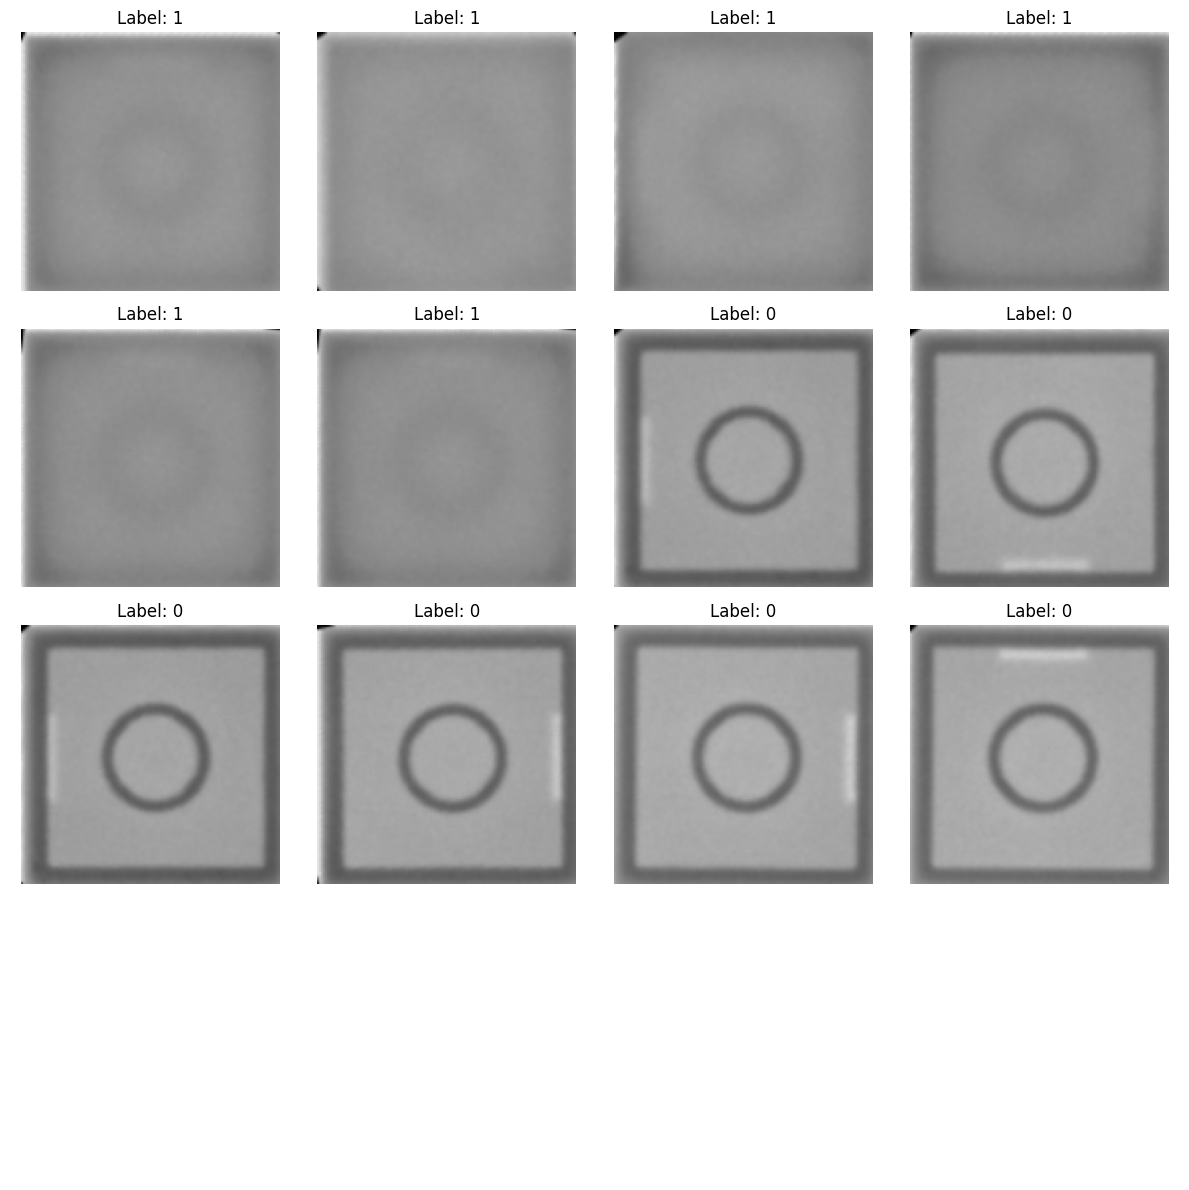

In [ ]:
import matplotlib.pyplot as plt
import math

# Get the ize of the dataset
num_images = len(dataset)

# Calculate the grid size to display the images(e.g., 8x8 if there are 64 images)
grid_size = math.ceil(math.sqrt(num_images))

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))

# Flatten the axes array for easy iteration (if grid_size > 1)
axes = axes.flatten()

# Iterate over the dataset and display each image in the grid
for i in range(num_images):
    image, label = dataset[i]

    # Display the image in the appropriate subplot
    axes[i].imshow(image.permute(1, 2, 0))  # Permute dimensions if using PyTorch tensors
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f'Label: {label}')

# Hide any unused subplots
for i in range(num_images, grid_size * grid_size):
    axes[i].axis('off')

# Adjust layout and display the grid
plt.tight_layout()
plt.show()


Data augmentation

We apply two type of data augmentation processes : Blur and Illumination

In [ ]:
import kornia
import random
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_segmentation_masks

#-------------------------------
####Clone one positive template and one negative template and create 12 copies :

#generate random index for each good and bad batches
good_rand_indx = random.randint(0, 5) #a random idx from 0 to 6
bad_rand_indx = random.randint(6, 11) #a random idx from 6 to 12

#Cloning one random image form the good and bad sets
img2clone_g, label2clone_g = dataset[good_rand_indx]
img_cloned_g = img2clone_g.clone().detach()

img2clone_b, label2clone_b = dataset[bad_rand_indx]
img_cloned_b = img2clone_b.clone().detach() # Clone and detach the tensor

#Iterate the 2 clones 12 times to create 2 batches of good and bad images
batch_good = img_cloned_g[None].repeat(12, 1, 1, 1)
batch_bad = img_cloned_b[None].repeat(12, 1, 1, 1)


#-------------------------------

###Concatenate the 2 separate batches into a single one and apply data augmentation

# Concatenate the good and bad batches
batch_aug = torch.cat([batch_good, batch_bad], dim=0)

#Functions to apply augmentation
aug1 = kornia.augmentation.RandomGaussianBlur(kernel_size=(9, 9), sigma=(1.0, 3.0), p=1.0)
aug2 = kornia.augmentation.RandomLinearIllumination(gain=(0.1, 0.2), sign=(-1.0, 1.0), p=1, same_on_batch=True, keepdim=True)


#Augmentation processes
process1 = aug1(batch_aug.clone().detach())
process2 = aug2(batch_aug.clone().detach())
batch_aug = torch.cat([process1, process2], dim=0)


#Create labels for augmented data
aug_labels = [1] * batch_good.size()[0]+  [0] * batch_bad.size()[0] + [1] * batch_good.size()[0] +  [0] * batch_bad.size()[0]

#-------------------------------

###Add augmented data to the dataset
dataset.add_augmented_data(batch_aug, aug_labels)

# Recreate a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [ ]:
#Print created  labels for visualization
print(aug_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Visualize the entire final dataset

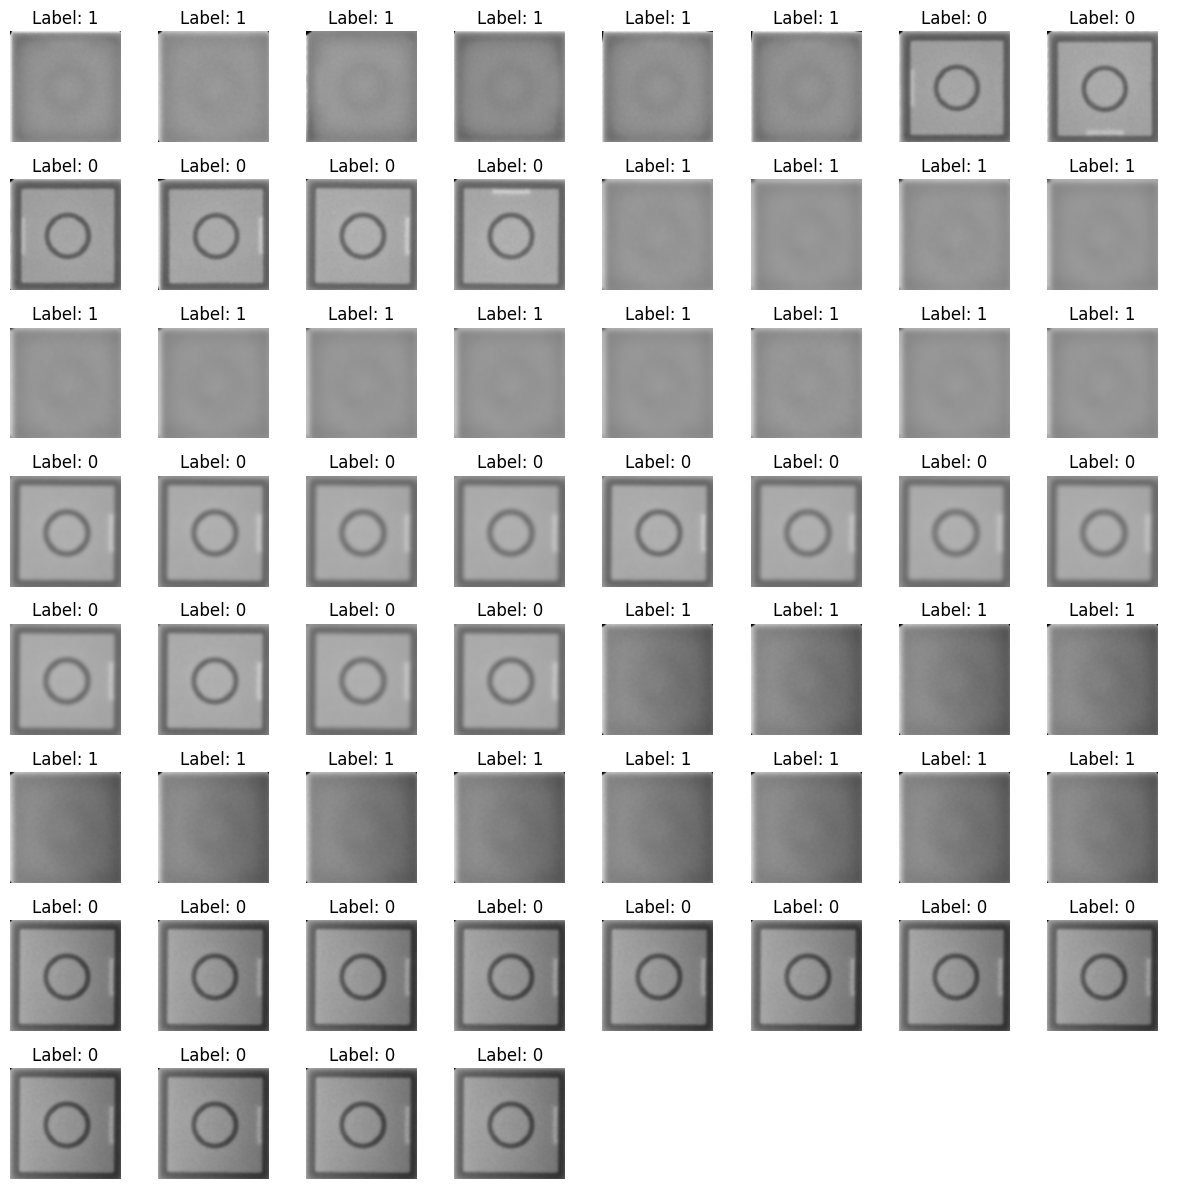

In [ ]:
# Determine the size of the dataset
num_images = len(dataset)

# Calculate the grid size (e.g., 8x8 if there are 64 images)
grid_size = math.ceil(math.sqrt(num_images))

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))

# Flatten the axes array for easy iteration (if grid_size > 1)
axes = axes.flatten()

# Iterate over the dataset and display each image in the grid
for i in range(num_images):
    image, label = dataset[i]

    # Display the image in the appropriate subplot
    axes[i].imshow(image.permute(1, 2, 0))  # Permute dimensions if using PyTorch tensors
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f'Label: {label}')

# Hide any unused subplots
for i in range(num_images, grid_size * grid_size):
    axes[i].axis('off')

# Adjust layout and display the grid
plt.tight_layout()
plt.show()


The NN :

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(32 * 30 * 30, 128)  # input size is 128x228
        self.fc2 = nn.Linear(128, 2)  # Two output classes: "good" and "bad"

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 30 * 30)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, define the loss function and the optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

# Initialize lists to store epoch numbers and corresponding average losses
epochs = []
average_losses = []

num_epochs = 35  # Set the number of epochs

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Compute average loss for this epoch
    avg_loss = running_loss / len(dataloader)

    # Record epoch number and average loss
    epochs.append(epoch + 1)
    average_losses.append(avg_loss)

    # Print statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

print('Finished Training')

# Plotting the loss evolution
plt.figure(figsize=(10, 6))
plt.plot(epochs, average_losses, marker='o', linestyle='-', color='b')
plt.title('Loss Evolution Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()


In [ ]:
# To evaluate, we need to turn off gradients
model.eval()  # Set the model to evaluation mode

# Use the same DataLoader or create a separate one for the test dataset
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Take a subset of the dataset for testing

In [ ]:
from torch.utils.data import Subset

# Define the indices for the subset
indices = list(range(9))

# Create the subset
testset = Subset(dataset, indices)

# Create the DataLoader
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Define the classes (adjust this list according to your dataset)
classes = ["0", "1"]  # Replace with your actual class names

# Define the imshow function to display images
def imshow(img):
    """Helper function to display an image."""
    img = img.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.imshow(img)
    plt.axis('off')

# Assume `testloader` is your DataLoader for the test set
# Get a batch of images and labels
dataiter = iter(testloader)
images, labels = next(dataiter)

# Assume `testloader` is your DataLoader for the test set
# Assume `model` is your trained model
model.eval()  # Set the model to evaluation mode

# Get predictions
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Create a grid from the batch of images
img_grid = torchvision.utils.make_grid(images)  # Move images back to CPU for displaying

# Print images
plt.figure(figsize=(10, 10))
imshow(img_grid)
plt.show()

# Print ground truth labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

# Print predictions
print('Predictions: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(len(predicted))))









In [ ]:
# Step 1: Configure Git
!git config --global user.name "Anahide-Vanian"
!git config --global user.email "vanian.anahide@gmail.com"

# Step 2: Clone the GitHub repository
!git clone https://github.com/Anahide-Vanian/CNNClassifier4Lego.git
%cd your-repository

# Step 3: Save your notebook or code
!cp data_dir

# Step 4: Add files and commit changes
!git add .
!git commit -m "Added new notebook"

# Step 5: Push changes to GitHub
!git push origin main
